In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
import requests
import time
from decimal import Decimal, getcontext
from urllib.parse import urlencode

%matplotlib inline

warnings.filterwarnings('ignore')


d:\anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
assessments         = 'https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'
studentAssessment   = 'https://disk.yandex.ru/d/DYd4M5b_8RETsA'
studentRegistration = 'https://disk.yandex.ru/d/lqHnH8NOZ458iw'
courses             = 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw'

In [3]:
def Yandex_df(url):
    time.sleep(1)
    baza = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    url = baza + urlencode(dict(public_key=url))
    response = requests.get(url)
    return pd.read_csv(response.json()['href'])

In [4]:
assessments = Yandex_df(assessments)
studentAssessment = Yandex_df(studentAssessment)
studentRegistration = Yandex_df(studentRegistration)
courses = Yandex_df(courses)


In [5]:
assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [6]:
assessments.shape

(206, 6)

In [7]:
studentAssessment.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [8]:
studentAssessment.shape


(173912, 5)

In [9]:
studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [10]:
studentRegistration.shape

(32593, 5)

In [11]:
courses.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [12]:
assessments.isna().sum()


code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [13]:
# мерджим датасеты
df = assessments.merge(studentAssessment, on = 'id_assessment')\
.merge(courses, on = ['code_module','code_presentation'])\
.merge(studentRegistration, on = ['code_module','code_presentation','id_student'])

In [14]:
# ставим флаг успешной сдачи
df['succes'] = np.where(df['score'] >= 40,1,0) 

In [15]:
#Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

In [16]:
df_succes = df[(df['succes'] == 1) & (df['assessment_type'] == 'Exam')]

In [17]:
# группируем по студентам, вычисляем кол-во успешных сданныхх экзаменов 
answer = df_succes\
.groupby('id_student',as_index=False)\
.agg({'code_module':'count'})\
.code_module\
.value_counts()

print(f'Сдали только 1 экзамен всего {answer[1]} студентов')

Сдали только 1 экзамен всего 3802 студентов


In [18]:
# Выяви самый сложный и самый простой экзамен: 
# найди курсы и экзамены в рамках курса, которые 
# обладают самой низкой и самой высокой завершаемостью*

In [19]:
"""Группируем по курсу и семестру, дальше считаем кол-во 
попыток и колличество успешных попыток сдачи экзаемна"""

df_group_semestr = df.query("assessment_type =='Exam'")\
.groupby(['code_module','code_presentation'],as_index=False)\
.agg(succes=('succes','sum'), total = ('succes','count'))

# Высчитываем долю
df_group_semestr['perc'] = df_group_semestr['succes'] / df_group_semestr['total']

hard = df_group_semestr\
.sort_values('perc').iloc[0]

easy = df_group_semestr\
.sort_values('perc', ascending= False).iloc[0]

print(f'Самый сложный курс в разрезе курсов и семестров является курс: {hard.code_module}, семестр: {hard.code_presentation}, процент проходимости: {hard.perc:.2%}')

print(f'Самый легкий курс в разрезе курсов и семестров является курс: {easy.code_module}, семестр: {easy.code_presentation}, процент проходимости: {easy.perc:.2%}')


Самый сложный курс в разрезе курсов и семестров является курс: DDD, семестр: 2013B, процент проходимости: 83.72%
Самый легкий курс в разрезе курсов и семестров является курс: DDD, семестр: 2014B, процент проходимости: 92.56%


In [20]:
"""Группируем по курсу, дальше считаем кол-во 
попыток и колличество успешных попыток сдачи экзаемна"""

df_group_module = df.query("assessment_type =='Exam'")\
.groupby(['code_module'],as_index=False)\
.agg(succes=('succes','sum'), total = ('succes','count'))

# Высчитываем долю
df_group_module['perc'] = df_group_module['succes'] / df_group_module['total']

hard = df_group_module\
.sort_values('perc').iloc[0]

easy = df_group_module\
.sort_values('perc', ascending= False).iloc[0]

print(f'Самый сложный курс в разрезе курсов: {hard.code_module}, процент проходимости: {hard.perc:.2%}')

print(f'Самый легкий курс в разрезе курсов: {easy.code_module}, процент проходимости: {easy.perc:.2%}')


Самый сложный курс в разрезе курсов: CCC, процент проходимости: 87.89%
Самый легкий курс в разрезе курсов: DDD, процент проходимости: 88.99%


In [21]:
#По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

In [22]:
mean_dt = df.query("(succes == 1) & (assessment_type == 'Exam')")\
.groupby('code_module',as_index=False).agg({'date_submitted':'mean'})

mean_dt


,code_module,date_submitted
0,CCC,239.345217
1,DDD,237.976006


#### Средний срок сдачи экзамена CCC - 239 дней 

#### Средний срок сдачи экзамена DDD - 238 дней

In [23]:
# Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3)

In [24]:
#берем студнетов у которых заполенная дата регистрации
df_reg = studentRegistration[studentRegistration['date_registration'].notna()]

#выбераем студентов с датой отмены рагистрации
cancelation = df_reg.query('date_unregistration > date_registration')\
.groupby('code_module',as_index=False).agg({'id_student':'nunique'})

#Ссчитаем общее кол-во студнетов
total_student = df_reg\
.groupby('code_module',as_index=False).agg({'id_student':'nunique'})

df_grouped = total_student.merge(cancelation, on = ['code_module'])\
.rename(columns={'id_student_x':'total','id_student_y':'out'})

In [25]:
# Самый большой отток буду брать в абсолютных величинах,
# с точки зрения не бюджетных мест - абсолютное колличество = потери в деньгах

In [26]:
# Самые популярные курсы
df_grouped.sort_values('total',ascending = False)\
[['code_module','total']].head(3)

,code_module,total
1,BBB,7683
5,FFF,7387
3,DDD,5840


In [27]:
# самый большой отток 
df_grouped.sort_values('out',ascending = False)\
[['code_module','out']].head(3)
# в принципе логично, там, куда больше поступают - больше и уходят

,code_module,out
1,BBB,2302
5,FFF,2235
3,DDD,2056


In [28]:
#Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

In [29]:

df_sample = df.query("assessment_type=='Exam'")

In [30]:
df_semestr = df_sample.groupby(['code_presentation'],as_index=False)\
.agg(succes=('succes','sum'), total = ('succes','count'), mean_dt= ('date_submitted','mean'))
df_semestr['succes_pec'] = df_semestr['succes'] / df_semestr['total']
hard_semest = df_semestr.sort_values('succes_pec').iloc[0]
slow_semest = df_semestr.sort_values('mean_dt',ascending=False).iloc[0]

print(f'Самый сложный семестр: {hard_semest.code_presentation}, процент завершаемости: {hard_semest.succes_pec:.2%}')
print(f'Самый долгий семестр: {slow_semest.code_presentation}, серднее время сдачи екзамена: {slow_semest.mean_dt:.1f} дня')


Самый сложный семестр: 2013B, процент завершаемости: 83.72%
Самый долгий семестр: 2014J, серднее время сдачи екзамена: 243.7 дня


6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [73]:
rfm = df.query('assessment_type=="Exam"').groupby('id_student',as_index=False)\
.agg(recency = ('date_submitted','mean')
     ,monetary = ('score','mean')
     ,cnt_succes = ('succes','sum')
     ,total_tests = ('succes','count'))

rfm['frequency'] = rfm['cnt_succes']/ rfm['total_tests']

In [74]:
rfm.head(1)

,id_student,recency,monetary,cnt_succes,total_tests,frequency
0,23698,243.0,80.0,1,1,1.0


In [75]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(10,7)}
        )

<Axes: xlabel='recency', ylabel='Density'>

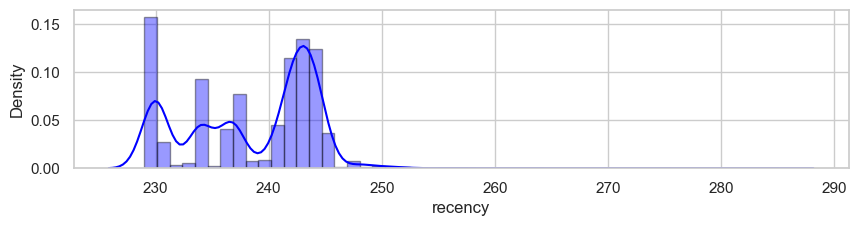

In [76]:
plt.subplot(3,1,1)
sns.distplot(rfm.recency
             ,kde=True
              ,color='blue'
             ,hist_kws={'edgecolor':'black'}
             )

In [77]:
rfm['recency'].describe()

count    4633.000000
mean      238.462227
std         5.653378
min       229.000000
25%       234.000000
50%       241.000000
75%       243.000000
max       285.000000
Name: recency, dtype: float64

In [78]:
# будем бить на 4 сегмента, < 234, 241,243 


In [79]:
rfm.recency.min()

229.0

<Axes: xlabel='monetary', ylabel='Density'>

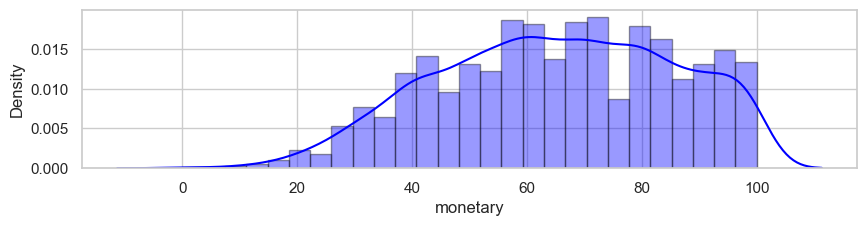

In [80]:
plt.subplot(3,1,2)
sns.distplot(rfm.monetary
            ,kde=True
             ,color='blue'
             ,hist_kws={'edgecolor':'black'}
            )

[Text(0, 0, '4069'), Text(0, 0, '536'), Text(0, 0, '28')]

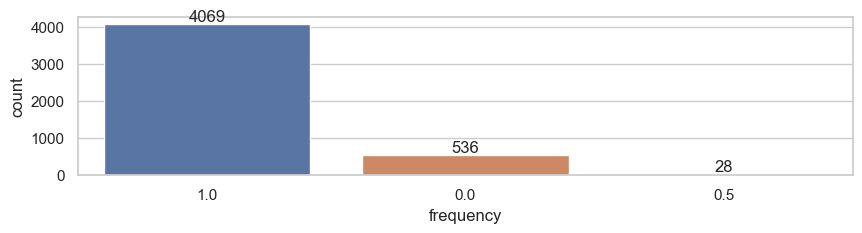

In [81]:
plt.subplot(3,1,2)

ax = sns.countplot(x=rfm['frequency'],
                   order=rfm['frequency'].value_counts(ascending=False).index)

abs_values = rfm['frequency'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

In [82]:
def m_score(row):
    # сегментируем по средней оценку по возрастанию от 1(плохо) до 4 (отлично)
    if row < 40:
        row = 1
    elif 40<= row <= 70:
        row = 2
    elif 70 < row <= 85:
        row = 3
    else:
        row = 4
    return row


def r_score(row):
    # сегментируем по времене сдачи экзамен, оценкуе не подлежит
    if row < 234:
        row = 1
    elif 234<= row <= 241:
        row = 2
    elif 241 < row <= 243:
        row = 3
    else:
        row = 4
    return row

def f_score(row):
    ## сегмитруем по успешным экзаменам по возрастанию 1(не сдал ни одного), 0.5 (сдал половину) 1 = сдал все
    if row == 0:
        row = 1
    elif row == 0.5:
        row = 2
    else :
        row = 3
    return row

In [83]:
rfm['M'] = rfm['monetary'].apply(lambda x:m_score(x))
rfm['R'] = rfm['recency'].apply(lambda x:r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x:f_score(x))

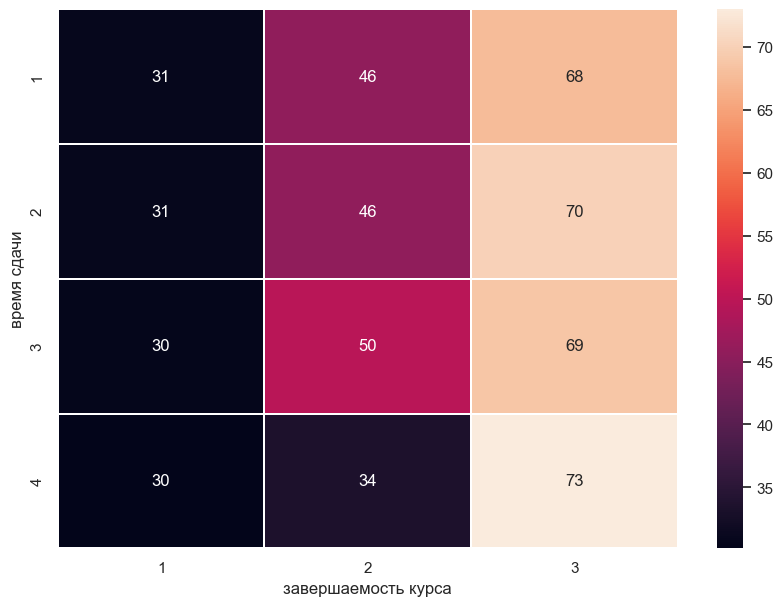

In [84]:
rfm_pivot = rfm.pivot_table(index="R",columns="F",values='monetary')
sns.heatmap(rfm_pivot, annot=True, linewidths=0.01)
plt.xlabel('завершаемость курса')
plt.ylabel('время сдачи')
plt.show()

In [85]:
'''
1. Тепловая карта показала, что лучше сдают те, кто дольше готовится
Завершаемость (frequency) обучения в итоговый анализ брать не буду, так как считаю, что она не показательна.
сегментировать буду по времени обучения и колличеству баллов.

Описание сегментации:
4x - Много баллов:

    41: Гении - набрали много баллов и потратили мало времени. Это отличные ученики, которые быстро усваивают материал.
    42, 43, 44: Отличники - набрали много баллов, потратили разное количество времени. Все они успешны, но у кого-то может уйти больше времени на достижение отличных результатов.

3x - Среднее количество баллов:

    31: Потенциальные отличники, либо очень самоуверенные - набрали среднее количество баллов, но потратили мало времени. Возможно, у них есть потенциал улучшить свои результаты.
    32, 33: Твердые хорошисты - набрали среднее количество баллов и потратили умеренное время. Это хорошие ученики с устойчивыми результатами.
    34: Усидчивые хорошисты - набрали среднее количество баллов, но потратили много времени. Они усердно работают для достижения своих результатов.

2x - Меньше среднего баллов:
    21: Потенциальные хорошисты - набрали меньше среднего баллов, но потратили мало времени. Есть потенциал для улучшения с увеличением усилий.
    22: Невнимательные троечники - набрали меньше среднего баллов и потратили умеренное время. Вероятно, у них проблемы с концентрацией или вниманием.
    23: Усидчивые, но с проблемами - набрали меньше среднего баллов, но потратили много времени. Сталкиваются с трудностями, несмотря на усилия.
    24: Потенциальные двоечники - набрали мало баллов, но потратили много времени. Имеют значительные проблемы с успеваемостью.

1x - Мало баллов:
    11, 12: Безответственные - набрали мало баллов и потратили мало времени. Низкая мотивация или интерес к обучению.
    13, 14: Не поддаются обучению по данному направлению - набрали мало баллов, потратили умеренное или много времени. Возможно, им тяжело дается данный предмет или направление, и они не показывают значительных успехов, несмотря на затраченные усилия.
 '''


'\n1. Тепловая карта показала, что чем лучше сдают те, кто дольше готовится\nЗавершаемость (frequency) обучения в итоговый анализ брать не буду, так как считаю, что она не показательна.\nсегментировать буду по времени обучения и колличества баллов.\n\nОписание сегментации:\n4x - Много баллов:\n\n    41: Гении - набрали много баллов и потратили мало времени. Это отличные ученики, которые быстро усваивают материал.\n    42, 43, 44: Отличники - набрали много баллов, потратили разное количество времени. Все они успешны, но у кого-то может уйти больше времени на достижение отличных результатов.\n\n3x - Среднее количество баллов:\n\n    31: Потенциальные отличники, либо очень самоуверенные - набрали среднее количество баллов, но потратили мало времени. Возможно, у них есть потенциал улучшить свои результаты.\n    32, 33: Твердые хорошисты - набрали среднее количество баллов и потратили умеренное время. Это хорошие ученики с устойчивыми результатами.\n    34: Усидчивые хорошисты - набрали сре

In [86]:
# ОцекаВремя
seg_dict = {
    '41': 'Гении',
    '42': 'Отличники',
    '43': 'Отличники',
    '44': 'Отличники',
    '31': 'Потенциальные отличники, либо очень самоуверенные',
    '32': 'Твердые хорошисты',
    '33': 'Твердые хорошисты',
    '34': 'Усидчивые хорошисты',
    '21': 'Потенциальные хорошисты',
    '22': 'Невнимательные троечники',
    '23': 'Усидчивые, но с проблемами',
    '24': 'Потенциальные двоечники',
    '11': 'Безответственные',
    '12': 'Безответственные',
    '13': 'Не поддаются обучению по данному направлению',
    '14': 'Не поддаются обучению по данному направлению'
}

In [87]:
rfm['RFM_score'] =  rfm['M'].map(str) +  rfm['R'].map(str)
rfm['segment'] = rfm['RFM_score'].replace(seg_dict)

In [88]:
rfm.segment.value_counts()

segment
Отличники                                            741
Твердые хорошисты                                    679
Невнимательные троечники                             625
Усидчивые, но с проблемами                           611
Потенциальные хорошисты                              507
Потенциальные двоечники                              382
Безответственные                                     275
Не поддаются обучению по данному направлению         268
Потенциальные отличники, либо очень самоуверенные    217
Усидчивые хорошисты                                  165
Гении                                                163
Name: count, dtype: int64

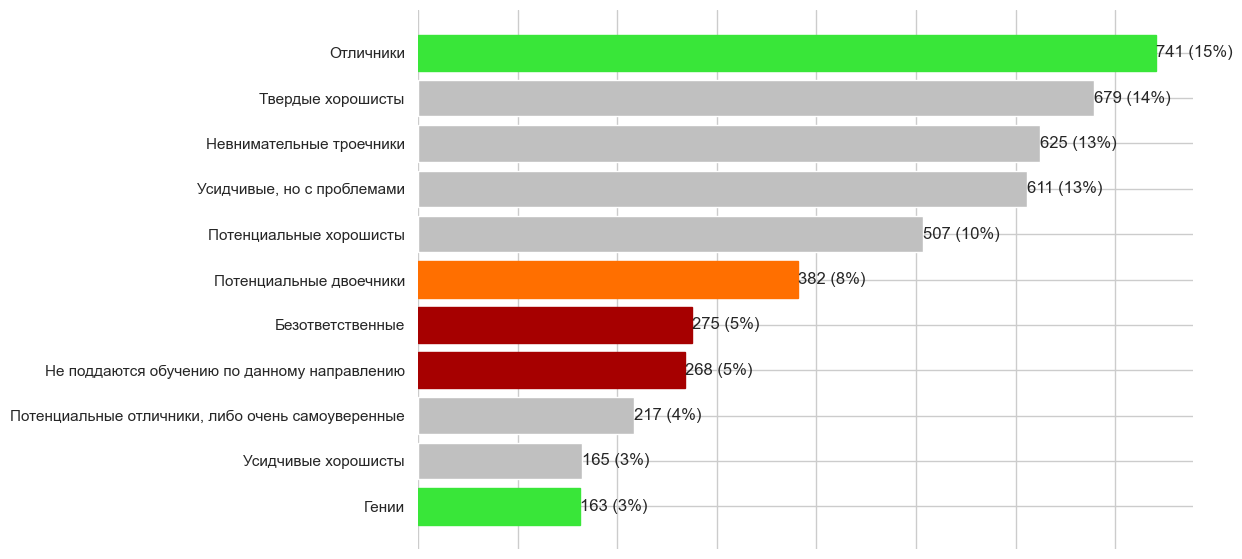

In [89]:
segments_counts = rfm['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Гении','Отличники']:
            bar.set_color('#39E639')
        elif segments_counts.index[i] in ['Безответственные', 'Не поддаются обучению по данному направлению']:
            bar.set_color('#A60000')
        elif segments_counts.index[i] in ['Потенциальные двоечники']:
            bar.set_color('#FF6F00')    
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [91]:
''' 
Проблемные зоны:
    10% студентов находятся в сегментах, где успеваемость критически низкая:
        13, 14: Не поддаются обучению по данному направлению.
        11, 12: Безответственные.
    8% студентов находятся на грани, которые потенциально могут перейти в проблемную зону:
        24: Потенциальные двоечники.

Зоны развития:
    Потенциальные отличники и хорошисты:
        31: Потенциальные отличники, либо очень самоуверенные.
        21: Потенциальные хорошисты.

Рекомендации:
    Работа с проблемными студентами:
        Ввести дополнительные занятия и консультации.

    Мотивация потенциальных отличников и хорошистов:
        Ввести поощрения за улучшение результатов (грамоты, стипендии).

    Поддержка студентов на грани:
        Разработать программы по улучшению навыков самоорганизации и управления временем.'''